In [1]:
# This code compares S_obs to S_pred using a predicted N_max and lognormal model of biodiversity
## Adapted from Fig3.py from https://github.com/LennonLab/ScalingMicroBiodiversity; Locey and Lennon, 2016 (LL2016)

In [2]:
import  matplotlib.pyplot as plt
import numpy as np
import random
import scipy as sc
from scipy import stats
import os
import sys
import statsmodels.stats.api as sms
import statsmodels.formula.api as smf
from statsmodels.sandbox.regression.predstd import wls_prediction_std
from statsmodels.stats.outliers_influence import summary_table
from numpy import log, log2, exp, sqrt, log10, pi
from scipy.optimize import fsolve
import scipy.optimize as opt
import pandas as pd #import patsy
import mpmath as mpm
from scipy.optimize import fsolve
from math import erf, pi
import linecache
import math
from statsmodels.iolib.smpickle import load_pickle
import pandas as pd

In [3]:
## Added an intermediate function find x0 guess for opt.fsolve function
def findGuess(N, Nmax, Nmin=1):
    tenthRange = np.arange(0.0, 0.3, 0.01)
    vals = []
    for i in tenthRange:
        vals.append(alphaFunction(i,N,Nmax,Nmin))
    lowestErrIndex = np.argmin(abs(np.asarray(vals)))
    bestGuess = tenthRange[lowestErrIndex]
    hundredthRange = np.arange(bestGuess-0.05, bestGuess+0.05,0.001)
    vals = []
    for i in tenthRange:
        vals.append(alphaFunction(i,N,Nmax,Nmin))
    lowestErrIndex = np.argmin(abs(np.asarray(vals)))
    bestGuess = hundredthRange[lowestErrIndex]
    return bestGuess

In [4]:
# Equation 11 from Curtis et al. (2002); Defines N as a function of Nmax, Nmin, and alpha.  
def alphaFunction(a, N, Nmax, Nmin=1):
    y = sqrt(pi*Nmin*Nmax)/(2.0*a) * exp((a * log2(sqrt(Nmax/Nmin)))**2.0)
    y = y * exp((log(2.0)/(2.0*a))**2.0)
    y = y * erf(a * log2(sqrt(Nmax/Nmin)) - log(2.0)/(2.0*a))
    y += erf(a * log2(sqrt(Nmax/Nmin)) + log(2.0)/(2.0*a))
    y -= N # subtract N to solve for a in getS function
    return y

# Equation 10 from Curtis et al. (2002); yields the total number of species
def s2(a, Nmax, Nmin=1): 
    return sqrt(pi)/a * exp( (a * log2(sqrt(Nmax/Nmin)))**2)

# Predict Nmax from scaling function Nmax = cNmax**z
def getNmax(N, b, slope):
    return 10 ** (b + slope*(log10(N)))



In [5]:
# Predict the number of species by estimating Nmax, solving for alpha, and
#def getS(Nrange, db, dz, guess, predictNmax=True):
def getS(Nrange, db, dz, predictNmax=True,makeGuess=True):
    Dlist = []
    Slist_ln = []
    Nlist = []

    for i in range(1000):
        N = float(np.random.uniform(Nrange)[1])
        Nlist.append(N)

        Nmax = 0
        if predictNmax == True:
            Nmax = getNmax(N, db, dz)
        else:
            Nmax = np.random.uniform(NmaxRange)[1] ### This is legacy from LL2016 code

        Dlist.append(Nmax)
        Nmin = 1
        if makeGuess == False:
            guess = 0.1060 # guess for global estimate from original LL2016 code 
        else:
            guess = findGuess(N, Nmax, Nmin)
        alpha = opt.fsolve(alphaFunction, guess, (N, Nmax, Nmin))[0]
 
        S2 = s2(alpha, Nmax, 1)
        Slist_ln.append(S2)

    #print 'guess = %f' % guess
    Slist_ln = log10(Slist_ln)

    S_ln = np.mean(Slist_ln)
    S_sorted = np.sort(Slist_ln)
    
    lowPred = S_sorted[24]
    highPred = S_sorted[974]
    return [S_ln, lowPred, highPred]

In [6]:
def fitLL2016():
    #############################################
    ### Prepare LL2016 Data with subsurface data
    #############################################
    tail = str()
    if ones is False:
        tail = '-SADMetricData_NoMicrobe1s.txt'
    elif ones is True:
        tail = '-SADMetricData.txt'

    datasets = []
    GoodNames = []
    emp = str()

    if condition == 'open': emp = 'EMPopen'
    elif condition == 'closed': emp = 'EMPclosed'

    GoodNames = [emp, 'TARA', 'HMP', 'BIGN', 'BOVINE', 'CHU', 'LAUB', 'SED', 'HUMAN', 'CHINA', 'CATLIN', 'FUNGI']
    GoodNames.append('subClosed')

    its = 1
    for name in os.listdir(mydir +'data/micro'):
        if name in GoodNames: pass
        else: continue

        path = mydir+'data/micro/'+name+'/'+name+tail
        numlines = sum(1 for line in open(path))
        datasets.append([name, 'micro', numlines])

    for name in os.listdir(mydir +'data/subsurface'):
        if name in GoodNames: pass
        else: continue

        path = mydir+'data/subsurface/'+name+'/'+name+tail
        num_lines = sum(1 for line in open(path))
        datasets.append([name, 'subsurface', num_lines])


    if sampling <= 500: its = 100
    else: its = 100

    for i in range(its):

        Nlist, Slist, klist, NmaxList = [[],[],[],[]]

        for dataset in datasets:
            radDATA = []
            name, kind, numlines = dataset
            lines = []

            small_mgrast = ['BIGN', 'BOVINE', 'CHU', 'LAUB', 'SED']
            big_mgrast = ['HUMAN', 'CHINA', 'CATLIN', 'FUNGI', 'HYDRO']

            if kind == 'micro':
                if name in small_mgrast:
                    lines = np.random.choice(range(1, numlines+1), 160, replace=True) # 40

                elif name in big_mgrast:
                    lines = np.random.choice(range(1, numlines+1), 400, replace=True) # 100

                else:
                    lines = np.random.choice(range(1, numlines+1), 400, replace=True) # 100
                path = mydir+'data/micro/'+name+'/'+name+tail

            elif kind == 'subsurface':
                lines = range(1, numlines+1)
                path = mydir+'data/subsurface/'+name+'/'+name+tail

            for line in lines:
                data = linecache.getline(path, line)
                radDATA.append(data)

            ct = 0
            for data in radDATA:
                data = data.split()
                if data == []: continue
                name, kind, N, S, Var, Evar, ESimp, EQ, O, ENee, EPielou, EHeip, BP, SimpDom, Nmax, McN, skew, logskew, chao1, ace, jknife1, jknife2, margalef, menhinick, preston_a, preston_S = data

                N = float(N)
                S = float(S)
                Nmax = float(Nmax)

                ct += 1
                Nlist.append(float(np.log10(N)))
                Slist.append(float(np.log10(S)))

                NmaxList.append(float(np.log10(Nmax)))
                klist.append('DarkCyan')

        Nlist, Slist, NmaxList = zip(*sorted(zip(Nlist, Slist, NmaxList)))
        Nlist = list(Nlist)
        Slist = list(Slist)
        NmaxList = list(NmaxList)

        ####Regression for Dominance (Nmax) vs. N
        d = pd.DataFrame({'N': Nlist})
        d['Nmax'] = NmaxList
        f = smf.ols('Nmax ~ N', d).fit()
        return f


In [7]:
def getR2(obs, preds):
    obs = np.asarray(obs)#.astype(float)
    preds = np.asarray(preds)#.astype(float)
    numerator = sum((obs-preds)**2)
    denom = sum((obs-np.mean(obs))**2)
    R2 = 1.-numerator/denom
    return R2

In [8]:
#### get otu subsets

### remove this part
#f = load_pickle("Nreads_Dominance_fit.pickle")
#db = f.params[0]
#dz = f.params[1]
##
#plt.figure()
#plt.plot(range(6)[1:], range(6)[1:], c = 'black')
#plt.plot(range(6)[1:], range(7)[2:], c = 'black', linestyle='dashed')
#plt.plot(range(6)[1:], range(6)[0:-1], c = 'black', linestyle='dashed')


def aggregateSampleBootstrap(color,b,z):
    sampleSizes = [5,10,20,40,50]
    #sampleSizes = [20]
    observations = []
    predictions = []
    for sampleSize in sampleSizes:
        for i in range(100):
            tmpOTU = otu.sample(sampleSize,axis=0)
            sampleIndices = list(tmpOTU.index)
            colsum = tmpOTU.sum(axis=0)
            Sobs = np.log10(colsum[colsum>0].size)
            Ncells = df['Total Cells'][sampleIndices].sum(axis=0)
            myNrange = [int(Ncells*.95),int(Ncells*1.05)]

            estimatedS, minS, maxS = getS(myNrange, b, z,predictNmax=True, makeGuess = True)
            plt.errorbar(Sobs,estimatedS,yerr=[[(estimatedS-minS),(maxS-estimatedS)]],c=color,fmt = 's',alpha=0.2)
            observations.append(Sobs)
            predictions.append(estimatedS)
    ################################################
    #### Continentatl dataset
    Ncells = df.sum(axis=0)['Total Cells']
    myNrange = [int(Ncells*.95),int(Ncells*1.05)]
    trueS = np.log10(float(16942))
    estimatedS, minS, maxS = getS(myNrange, b, z, predictNmax=True,makeGuess=True)
    plt.errorbar(trueS, estimatedS, yerr=[[(estimatedS-minS),(maxS-estimatedS)]], fmt = '*', c = color, markersize=10)
    print 'lognormal prediction of S for Continental Subsurface Dataset, using predicted Nmax:', '%.3e' % 10**estimatedS
    observations.append(trueS)
    predictions.append(estimatedS)
    ################################################
    print 'Pseudo-R2 = %f' % getR2(observations,predictions)
    #plt.errorbar(trueS, estimatedS, yerr=[[(estimatedS-minS),(maxS-estimatedS)]], fmt = '*', c = scatterColor)


In [9]:
## Make plot and species estimates
def predictionFigure(condition, ones, sampling, f,scatterColor,scatterLabel): # f is the fit (all micro, Nmax_reads, Nmax_cells)


    fs = 12 # font size used across figures
    metric = 'Richness, '+r'$log$'+r'$_{10}$'
    
    d_blist = []
    d_zlist = []



    if f == 'LL2016':
        for loceyIteration in range(1):
            f = fitLL2016()
            intercept = f.params[0]
            slope = f.params[1]
            d_blist.append(intercept)
            d_zlist.append(slope)
    else:
        R2 = f.rsquared
        intercept = f.params[0]
        slope = f.params[1]

        d_blist.append(intercept)
        d_zlist.append(slope)

    db = np.mean(d_blist)
    dz = np.mean(d_zlist)
    print 'Intercept: %f; Slope: %f' % (db,dz)

    ################################################
    ### All subsurface
    myNrange = [2*(10**29), 6*(10**29)] # estimated subsurface by CM 
    #myNrange = [9.2*(10**29), 31.7*(10**29)] # global estimate used by LL2016; they used a guess = 0.1060
   
    #estimatedS, minS, maxS = getS(myNrange, db, dz, guess, predictNmax=True)
    estimatedS, minS, maxS = getS(myNrange, db, dz, predictNmax=True,makeGuess=True)
    print 'lognormal prediction of S for Continental Subsurface, using predicted Nmax:', '%.3e' % 10**estimatedS#S_ln
    print '%.3e' % 10**minS#S_sorted[24]
    print '%.3e' % 10**maxS#S_sorted[974]
    #####################################
    ###########
    
    aggregateSampleBootstrap(scatterColor,db,dz)

#### Plots individual samples
    predGT = []
    obsGT = []
    predLower = []
    predUpper = []
    R2numerator = []

    for row in range(51): # 51 rows
        groundTruth = float(np.log10(df['closedref'][row]))
        Ncells = df['Total Cells'][row]
        myNrange = [int(Ncells*.95),int(Ncells*1.05)]
#        if myNrange[0]>1e10:
        estimatedS, minS, maxS = getS(myNrange, db, dz,predictNmax=True, makeGuess = True)
        R2numerator.append((float(groundTruth)-float(estimatedS))**2)
        predGT.append(estimatedS)
        predLower.append(estimatedS-minS)
        predUpper.append(maxS-estimatedS)
        obsGT.append(groundTruth)
        plt.errorbar(groundTruth,estimatedS,yerr=[[(estimatedS-minS),(maxS-estimatedS)]],c = scatterColor,fmt = 'o',alpha=0.5)


#    print len(obsGT)
#    R2 = 1-sum(np.asarray(R2numerator))/sum((np.log10(df['closedref'])-np.mean(np.log10(df['closedref'])))**2)
#    print 'R2 %s: %f' % (scatterLabel,R2)
#    print predLower, predUpper
#    yerr = [np.asarray(predLower),np.asarray(predUpper)]

#    plt.errorbar(np.asarray(obsGT), np.asarray(predGT), yerr=yerr,fmt = 'o',c = scatterColor,alpha = 0.5, label = scatterLabel)
        
    return


Ncells Nmax Scaling
Intercept: 1.643944; Slope: 0.294239
lognormal prediction of S for Continental Subsurface, using predicted Nmax: 9.421e+09
1.713e+09
1.582e+10
lognormal prediction of S for Continental Subsurface Dataset, using predicted Nmax: 1.284e+03
Pseudo-R2 = -22.739915


/Users/cmagnabosco/anaconda/lib/python2.7/site-packages/scipy/optimize/minpack.py:161: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Nreads Nmax Scaling
Intercept: -0.583545; Slope: 0.997789
lognormal prediction of S for Continental Subsurface, using predicted Nmax: 1.376e+09
6.592e+08
1.788e+09
lognormal prediction of S for Continental Subsurface Dataset, using predicted Nmax: 3.281e+04
Pseudo-R2 = -1.358852
LL2016 Scaling
Intercept: -0.405508; Slope: 0.928071
lognormal prediction of S for Continental Subsurface, using predicted Nmax: 1.289e+12
4.364e+11
1.912e+12
lognormal prediction of S for Continental Subsurface Dataset, using predicted Nmax: 1.807e+05
Pseudo-R2 = -19.179214


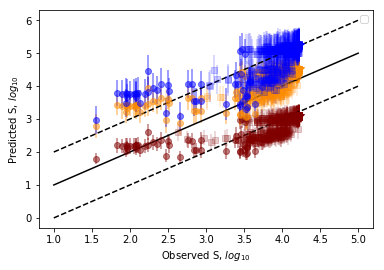

In [10]:
mydir = os.path.expanduser("~/Desktop/ScalingMicroBiodiversity-master/")
mydir2 = os.path.expanduser("~/")
pi = math.pi
cellDominance =  load_pickle("Ncells_Dominance_fit.pickle")
readDominance = load_pickle("Nreads_Dominance_fit.pickle")

df = pd.read_csv('Ncells_S_per_site.csv')
otu = pd.read_csv('closed_reference_OTU_table.csv',header=None)


EMPcondition = ['closed']
Singletons = [True]
Samplings = [1000]

plt.figure()
plt.plot(range(6)[1:], range(6)[1:], c = 'black')
plt.plot(range(6)[1:], range(7)[2:], c = 'black', linestyle='dashed')
plt.plot(range(6)[1:], range(6)[0:-1], c = 'black', linestyle='dashed')


for condition in EMPcondition:
    for ones in Singletons:
        for sampling in Samplings:
            print 'Ncells Nmax Scaling'        
            predictionFigure(condition, ones, sampling,cellDominance,'maroon',r'$N_{max}$'+' scaling with '+r'$N_{cells}$')
            print 'Nreads Nmax Scaling'
            predictionFigure(condition, ones, sampling,readDominance, 'darkorange',r'$N_{max}$'+' scaling with '+r'$N_{reads}$')
            print 'LL2016 Scaling'
            predictionFigure(condition, ones, sampling,'LL2016','blue',r'$N_{max}$'+' from LL2016 and '+ r'$N_{reads}$')
plt.xlabel('Observed S, '+r'$log_{10}$')
plt.ylabel('Predicted S, '+r'$log_{10}$')
plt.legend()
plt.savefig('FigSXX_from_JupyterNotebook_bootstrap_and_obs.pdf', dpi=300)
plt.show()


In [11]:
print np.min(df['Total Cells'])
print np.max(df['Total Cells'])


1460000
885000000000
